In [9]:
%pylab inline
%matplotlib inline
import numpy as np
from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [10]:
# Data import 

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    path = os.path.join(os.getcwd(), hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(path):
        with open(path, 'rb') as f:
            dat = f.read()
    else:
        with open(path, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()

X_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
Y_train = fetch('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:]
X_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
Y_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

# Classes definition

In [65]:
# Layer function definition (from MNIST Classifier)

import abc

class LayerFunction:
    __metaclass__ = abc.ABCMeta

    def __call__(self, *args, **kwargs):
        return self.evaluate(*args, **kwargs)
        
    @abc.abstractmethod
    def evaluate(self, *args, **kwargs):
        pass
    
    @abc.abstractmethod
    def backprop(self):
        pass


# Activation function definition

class ActivationFunction(LayerFunction):
    
    def __init__(self, axis=1):
        self.axis = axis
    

class ReLU(ActivationFunction):
    
    def evaluate(self, x):
        return np.maximum(x, 0)
    
    def backprop(self, dD, x):
        return (x > 0).astype(int)*dD


class LogSoftmax(ActivationFunction):
        
    def evaluate(self, x):
        x = x - x.max(1).reshape(-1, 1)
        x = x - np.log(np.exp(x).sum(1)).reshape(-1, 1)
        return x
            
    def backprop(self, dD, x):
        exp_lsm = np.exp(self.evaluate(x))
        dLSM = dD - exp_lsm*dD.sum(axis=self.axis).reshape((-1, 1))
        return dLSM
    

# Loss function definition

class LossFunction(LayerFunction):

    def __init__(self, axis=0):
        self.axis = axis 
    

class NLLLoss(LossFunction):
    
    def evaluate(self, x, labels):
        if self.axis == 0:
            return -np.mean(x[np.arange(x.shape[0]), labels])
    
    def backprop(self, x, y):
        dx = np.zeros(x.shape, dtype=x.dtype)
        if self.axis == 0:
            dx[np.arange(x.shape[0]), y.T] = -1/len(y)
        return dx


class QuadraticLoss(LossFunction):
    
    def evaluate(self, x, labels):
        target = np.zeros(x.shape, dtype=x.dtype)
        target[:, labels] = 1
        return np.mean(np.sum((x-target)**2, axis=1))
                        
    def backprop(self, x, y):
        target = np.zeros(x.shape, dtype=x.dtype)
        target[:, y] = 1
        return 2*(x-target)

In [66]:
# Model definition

class NPClassifier:
    def __init__(self, l1=128, l2=10, with_biases=False, dtype=np.float32):
        self.l1 = l1
        self.l2 = l2
        self.with_biases = with_biases
        
        # For consistency
        np.random.seed(1337)
        
        # Kaiming weigth initialization
        # Uniform sampling
        # https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48
        self.w1 = np.random.uniform(-1., 1., size=(28*28, l1))/np.sqrt(28*28*l1).astype(dtype)
        self.w2 = np.random.uniform(-1., 1., size=(l1, l2))/np.sqrt(l1*l2).astype(dtype)
                    
        if with_biases:
            # Uniform bias initialization
            # https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48
            self.b1 = np.random.uniform(-1., 1., size=(1, l1))/np.sqrt(l1).astype(dtype)
            self.b2 = np.random.uniform(-1., 1., size=(1, l2))/np.sqrt(l2).astype(dtype)

        # Layer activation functions
        self.act1 = ReLU()
        self.act2 = LogSoftmax()
    
    def __call__(self, x):
        return self.forward(x)
        
    def forward(self, x):
        x = x.dot(self.w1)
        if self.with_biases:
            x = x + self.b1
        x = self.act1(x)
        x = x.dot(self.w2)
        if self.with_biases:
            x = x + self.b2
        x = self.act2(x)

        return x
    
    def forward_backward(self, a0, y, loss_function):
                    
        # Forward pass
        z1 = a0.dot(self.w1)
        if self.with_biases:
            z1 = z1 + self.b1
        a1 = self.act1(z1)
        z2 = a1.dot(self.w2)
        if self.with_biases:
            z2 = z2 + self.b2
        a2 = self.act2(z2)
        
        # Loss and accuracy
        loss = loss_function(a2, y)
        accuracy = (np.argmax(a2, axis=1) == y).mean()

        # Backward pass
        da2 = loss_function.backprop(a2, y)
        dz2 = self.act2.backprop(da2, z2)
        db2 = dz2.mean(axis=0).reshape(1, self.l2) # Relevant
        dw2 = a1.T.dot(dz2) # Relevant
        da1 = dz2.dot(self.w2.T)
        dz1 = self.act1.backprop(da1, z1)
        db1 = dz1.mean(axis=0).reshape(1, self.l1) # Relevant
        dw1 = a0.T.dot(dz1) # Relevant
        da0 = dz1.dot(self.w1.T)
        
        # Return loss and gradients
        grad = {'w1': dw1, 'w2': dw2, 'b1': db1, 'b2': db2, 'a0': da0}
        return loss, accuracy, grad
    
    def step(self, lr, dw1, dw2, db1=None, db2=None):
        self.w1 = self.w1 - dw1 * lr
        self.w2 = self.w2 - dw2 * lr
        if self.with_biases:
            self.b1 = self.b1 - db1 * lr
            self.b2 = self.b2 - db2 * lr
    
    def train(self, inputs, labels, batch_size, epochs, loss_function, learning_rate):
        losses = []
        accuracies = []
        for i in trange(epochs):
            samples = np.random.randint(0, inputs.shape[0], size=batch_size)
            loss, acc, grad = self.forward_backward(inputs[samples], labels[samples], loss_function)
            losses.append(loss)
            accuracies.append(acc)
            self.step(learning_rate, grad['w1'], grad['w2'], grad['b1'], grad['b2'])
        return losses, accuracies
    
    def test(self, inputs, labels):
        forward = np.argmax(self.forward(inputs.reshape((-1, 28*28))), 1)
        return (forward == labels).mean()
        
    def reconstruct(self, label, epochs, loss_function, learning_rate):
        x = (np.random.uniform(-1., 1., size=(1, 28*28))/28 + 128).astype(np.float32)
        label = np.array([label])
        losses = []
        for i in trange(epochs):
            loss, _, grad = self.forward_backward(x, label, loss_function)
            x = x - learning_rate * grad['a0']
            losses.append(loss)
        return x, self(x), losses
    
    @classmethod
    def from_weights(cls, w1, w2, b1=None, b2=None):
        assert w1.shape[0] == 28*28
        classifier = cls()
        classifier.l1 = w1.shape[1]
        classifier.l2 = w2.shape[1]
        classifier.w1 = w1
        classifier.w2 = w2
        if b1 is not None and b2 is not None:
            assert b1.shape[1] == w1.shape[1] and b2.shape[1] == w2.shape[1]
            classifier.with_biases = True
            classifier.b1 = b1
            classifier.b2 = b2
        return classifier
        

# Model training

100%|██████████| 1000/1000 [00:01<00:00, 651.38it/s]


Accuracy: 0.9635


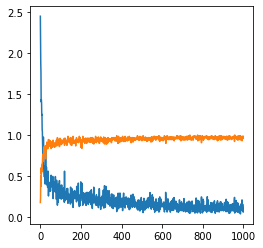

In [67]:
npmodel = NPClassifier()

batch_size = 128
epochs = 1000
learning_rate = 0.001
loss_function = NLLLoss()

inputs = X_train.reshape(-1, 28*28)
labels = Y_train

losses, accuracies = npmodel.train(inputs, labels, batch_size, epochs, loss_function, learning_rate)

figsize(4, 4)
plot(losses)
plot(accuracies)

print(f'Accuracy: {npmodel.test(X_test, Y_test)}')

# Image reconstruction

100%|██████████| 100000/100000 [00:18<00:00, 5320.21it/s]


1

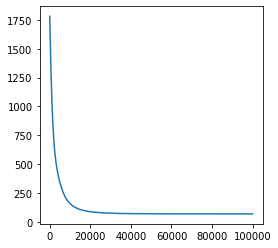

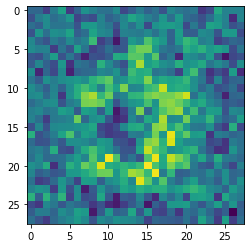

In [101]:
reconstruction_loss = QuadraticLoss()
label = 1
epochs = 100000
learning_rate = 0.1

sol, res, losses = npmodel.reconstruct(label, epochs, reconstruction_loss, learning_rate)

plot(losses)
figure()
imshow(sol.reshape(28, 28))
np.argmax(res)

100%|██████████| 100000/100000 [00:25<00:00, 3915.64it/s]


8

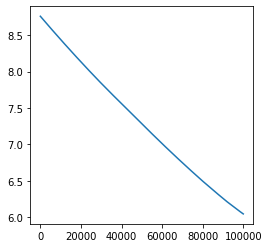

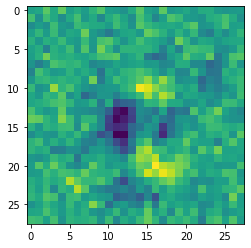

In [69]:
reconstruction_loss = NLLLoss()
label = 1
epochs = 100000
learning_rate = 0.1

sol, res, losses = npmodel.reconstruct(label, epochs, reconstruction_loss, learning_rate)

plot(losses)
figure()
imshow(sol.reshape(28, 28))
np.argmax(res)

In [129]:
# Album

# reconstruction_loss = QuadraticLoss()
# #reconstruction_loss = QuadraticLoss()

# epochs = 100000
# learning_rate = 0.1

# images = np.zeros(shape=(1, 28, 28), dtype=np.float32)
# predictions = []
# for i in range(10):
#     label = i
#     sol, res, _ = npmodel.reconstruct(label, epochs, reconstruction_loss, learning_rate)
#     print(sol.reshape(1, 28, 28).dtype, images.shape)
#     images = np.concatenate((images, sol.reshape(1, 28, 28)))
#     predictions.append(np.argmax(res))


# Trying to rule out noise

In [84]:
# Add new noise train data
noise_train_data = (np.random.uniform(-1., 1., size=(6000, 28, 28))/28 + 128).astype(np.float32)

X_train_noise = np.append(X_train, noise_train_data, axis=0)
Y_train_noise = np.append(Y_train, np.ones(6000, dtype=np.uint8)*10)

# Add new noise test data
noise_test_data = (np.random.uniform(-1., 1., size=(1000, 28, 28))/28 + 128).astype(np.float32)

X_test_noise = np.append(X_test, noise_test_data, axis=0)
Y_test_noise = np.append(Y_test, np.ones(1000, dtype=np.uint8)*10)


100%|██████████| 1000/1000 [00:01<00:00, 628.40it/s]


Accuracy: 0.9648181818181818


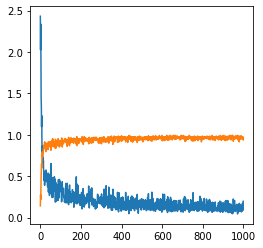

In [89]:
npmodel_noisy = NPClassifier(l2=11)

batch_size = 128
epochs = 1000
learning_rate = 0.001
loss_function = NLLLoss()

inputs = X_train_noise.reshape(-1, 28*28)
labels = Y_train_noise

losses, accuracies = npmodel_noisy.train(inputs, labels, batch_size, epochs, loss_function, learning_rate)

figsize(4, 4)
plot(losses)
plot(accuracies)

print(f'Accuracy: {npmodel_noisy.test(X_test_noise, Y_test_noise)}')

In [94]:
# Verify that it really does distinguish noise

np.argmax(npmodel_noisy(np.random.uniform(-1., 1., size=(10, 28*28))/28 + 128).astype(np.float32), axis=1)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

100%|██████████| 1000000/1000000 [03:42<00:00, 4490.42it/s]


7

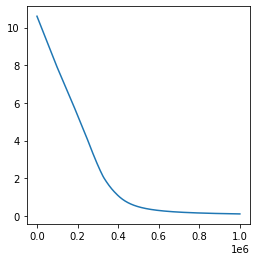

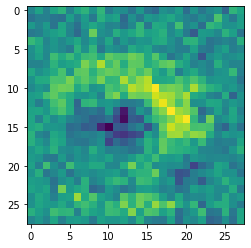

In [97]:
reconstruction_loss = NLLLoss()
label = 7
epochs = 1000000
learning_rate = 0.1

sol, res, losses = npmodel_noisy.reconstruct(label, epochs, reconstruction_loss, learning_rate)

plot(losses)
figure()
imshow(sol.reshape(28, 28))
np.argmax(res)